# Задание
Реализовать синтезирование лиц из LFW с помощью **DCGAN**

******

In [1]:
import numpy as np
import os
import pathlib
import warnings
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

----------------

# Load data. Preprocessing

In [3]:
train_ds, ds_info = tfds.load(
    'lfw', as_supervised=True, with_info=True, split='train')

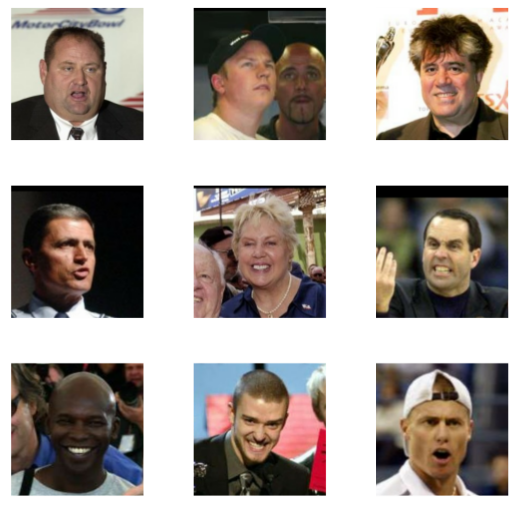

In [4]:
fig = tfds.show_examples(train_ds, ds_info=ds_info)

In [5]:
IMG_SIZE = 128
NUM_EPOCHS = 20
HALF_BATCH_SIZE = 10
BATCH_SIZE = HALF_BATCH_SIZE * 2

def prepare(label, img):
    img = tf.cast(img, tf.float32) / 255.
    return tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
num_steps = len(train_ds) - 1
num_steps

26465

# Build Deep Convolutional GAN (DCGAN)

In [6]:
# ******************************** Генератор ************************************

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Reshape((32, 32, 256)),
    tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),   
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'),
])
# ********************************** Дискриминатор ********************************

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2), 
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(256, kernel_size=2, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

# TRAIN

In [7]:
INPUT_DIM = 128
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def plot_results(samples):
    fig = plt.figure(figsize=(16, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j, ...].reshape(IMG_SIZE, IMG_SIZE, 3)))
        plt.xticks([]),
        plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.9685; G Loss: 0.6723; time taken ----> 7.84 sec


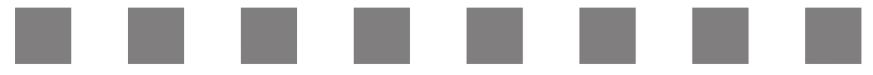

[Step 2000] D Loss: 0.0002; G Loss: 10.2144; time taken ----> 1697.9 sec


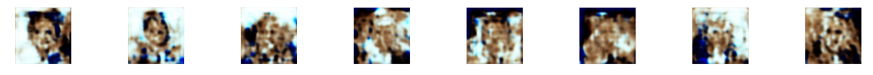

[Step 4000] D Loss: 0.2341; G Loss: 5.2735; time taken ----> 1643.33 sec


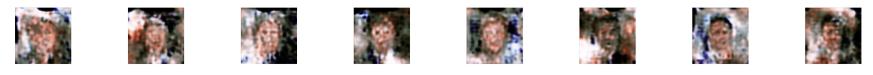

[Step 6000] D Loss: 0.2006; G Loss: 2.6992; time taken ----> 1622.59 sec


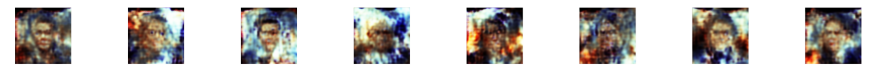

[Step 8000] D Loss: 1.2634; G Loss: 5.2741; time taken ----> 1605.47 sec


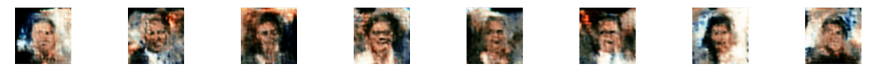

[Step 10000] D Loss: 0.4328; G Loss: 0.2834; time taken ----> 1623.23 sec


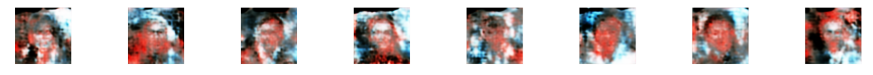

[Step 12000] D Loss: 0.4117; G Loss: 0.1783; time taken ----> 1629.7 sec


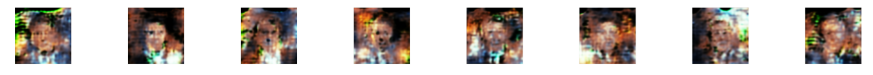

[Step 14000] D Loss: 0.7532; G Loss: 2.2998; time taken ----> 1631.03 sec


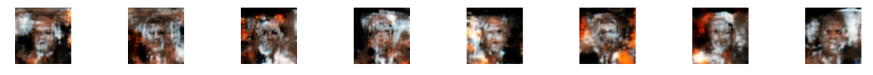

[Step 16000] D Loss: 0.8133; G Loss: 5.1139; time taken ----> 1619.63 sec


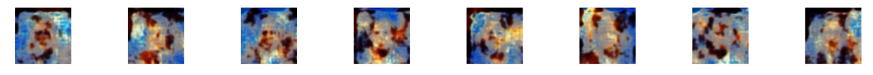

[Step 18000] D Loss: 0.4863; G Loss: 0.6984; time taken ----> 1630.68 sec


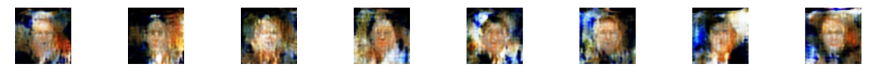

[Step 20000] D Loss: 0.7188; G Loss: 0.1067; time taken ----> 1627.26 sec


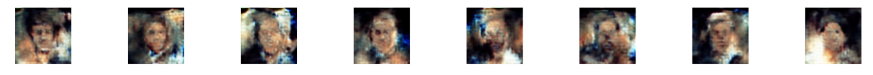

[Step 22000] D Loss: 0.1480; G Loss: 0.2714; time taken ----> 1633.01 sec


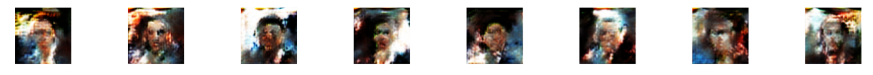

[Step 24000] D Loss: 0.7413; G Loss: 0.5333; time taken ----> 1616.56 sec


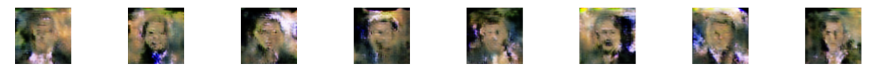

[Step 26000] D Loss: 0.4196; G Loss: 12.5788; time taken ----> 1575.04 sec


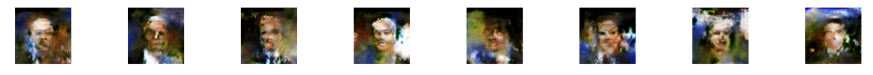

[Step 26465] D Loss: 0.1227; G Loss: 2.4894; time taken ----> 381.88 sec


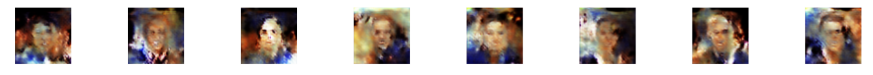

In [9]:
start = time.time()
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator =========================================================
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator ============================================================
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results =================================================
    
    if (step % 2000 == 0) or (step == num_steps):
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f;' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()), f'time taken ----> {round((time.time()-start), 2)} sec')
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise) 
        plot_results(syntetic_images)
        start = time.time() 

# TEST results

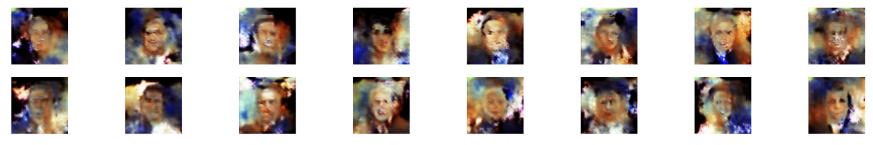

In [10]:
# работа генератора после обучения
noise = np.random.normal(0, 1, (16, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)

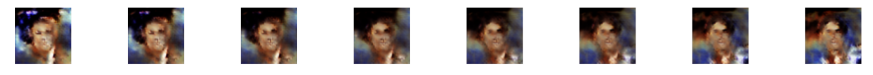

In [11]:
# Интерполяция в латентном пространстве
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)

In [13]:
path_to_file = os.path.join(pathlib.Path(os.getcwd()), "gen")
generator.save_weights(path_to_file)